<a href="https://colab.research.google.com/github/nikhil-xyz/Imdb-Sentiment-Analysis/blob/main/Imdb_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/nikhil-xyz/Imdb-Sentiment-Analysis.git

Cloning into 'Imdb-Sentiment-Analysis'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 21 (delta 3), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (21/21), 20.36 MiB | 6.15 MiB/s, done.


In [2]:
import pandas as pd

In [3]:
data = pd.read_csv('/content/Imdb-Sentiment-Analysis/Train.csv')

In [4]:
data.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [5]:
data.shape

(40000, 2)

In [6]:
data.isnull().sum()

text     0
label    0
dtype: int64

In [7]:
list(data.groupby('label'))

[(0,                                                     text  label
  0      I grew up (b. 1965) watching and loving the Th...      0
  1      When I put this movie in my DVD player, and sa...      0
  2      Why do people who do not know what a particula...      0
  3      Even though I have great interest in Biblical ...      0
  5      A terrible movie as everyone has said. What ma...      0
  ...                                                  ...    ...
  39984  I couldn't relate to this film. It failed to e...      0
  39985  Comedy? What's so funny about watching an ugly...      0
  39993  "The Best Movie of the 90's" "The Welsh Trains...      0
  39994  My girlfriend has the habit of going to Blockb...      0
  39997  My wife and I watched this movie because we pl...      0
  
  [20019 rows x 2 columns]),
 (1,                                                     text  label
  4      Im a die hard Dads Army fan and nothing will e...      1
  6      Finally watched this shocking

In [8]:
# # removing panctuations
# import string
# data['text'] = data['text'].apply(lambda word:[letters.lower() for letters in word if letters not in string.punctuation])
# data['text'] = data['text'].apply(lambda word:''.join(word))

In [9]:
data

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [10]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [11]:
# stops = set(stopwords.words('english'))
# stops.remove('no')
# stops.remove('not')
# stops

In [12]:
wnl = WordNetLemmatizer()
def preprocess(text):
  text = text.lower()
  text = text.split()
  text = [wnl.lemmatize(word) for word in text]
  text = ' '.join(text)
  return text

In [13]:
data['text'] = data['text'].apply(preprocess)

In [14]:
data.iloc[0]['text']

'i grew up (b. 1965) watching and loving the thunderbirds. all my mate at school watched. we played "thunderbirds" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my child to see the movie hoping they would get a glimpse of what i loved a a child. how bitterly disappointing. the only high point wa the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday morning one television channel still play rerun of the series gerry anderson and his wife created. jonatha frakes should hand in his director chair, his version wa completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionette with homo sapiens subsp. sapiens wa a huge error of judgment.'

In [15]:
data.iloc[0]['label']

0

In [16]:
import tensorflow as tf

In [17]:
X = data['text']
y = data['label'].values

In [18]:
vocab_size = 100000
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens = vocab_size, output_sequence_length=512, output_mode='int')
vectorizer.adapt(X.values)

In [19]:
vectorized_text = vectorizer(X.values)

In [20]:
vectorized_text.shape

TensorShape([40000, 512])

In [21]:
import pickle
pickle.dump({'config': vectorizer.get_config(),
             'weights': vectorizer.get_weights()}
            , open("vectorizer.pkl", "wb"))

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(16000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [23]:
len(dataset)

2500

In [24]:
train = dataset.take(int(len(dataset)*0.7))
val = dataset.skip(int(len(dataset)*0.7)).take(int(len(dataset)*0.2))
test = dataset.skip(int(len(dataset)*0.9)).take(int(len(dataset)*0.1))

In [25]:
train.as_numpy_iterator()

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Embedding

In [27]:

embedding_dims = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_dims))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(64, activation='relu'))

model.add(Dense(1, activation='sigmoid'))

In [28]:
model.compile(optimizer='adam',loss='BinaryCrossentropy', metrics=['accuracy'])

In [29]:
history = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
1750/1750 [==============================] - 178s 95ms/step - loss: 0.5358 - accuracy: 0.7327 - val_loss: 0.6201 - val_accuracy: 0.7566
Epoch 2/20
1750/1750 [==============================] - 74s 42ms/step - loss: 0.4241 - accuracy: 0.8106 - val_loss: 0.3624 - val_accuracy: 0.8917
Epoch 3/20
1750/1750 [==============================] - 65s 37ms/step - loss: 0.2356 - accuracy: 0.9117 - val_loss: 0.1509 - val_accuracy: 0.9507
Epoch 4/20
1750/1750 [==============================] - 62s 35ms/step - loss: 0.1318 - accuracy: 0.9538 - val_loss: 0.1008 - val_accuracy: 0.9720
Epoch 5/20
1750/1750 [==============================] - 59s 34ms/step - loss: 0.0809 - accuracy: 0.9744 - val_loss: 0.0596 - val_accuracy: 0.9833
Epoch 6/20
1750/1750 [==============================] - 60s 35ms/step - loss: 0.0467 - accuracy: 0.9865 - val_loss: 0.0422 - val_accuracy: 0.9884
Epoch 7/20
1750/1750 [==============================] - 59s 33ms/step - loss: 0.0335 - accuracy: 0.9907 - val_loss: 0.0293 

In [30]:
model.save('model.h5')

In [31]:
# history = (model.predict(test) > 0.5).astype(int)

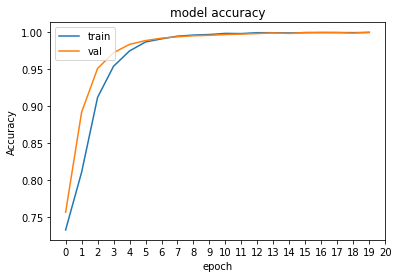

In [32]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xticks([i for i in range(21)])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

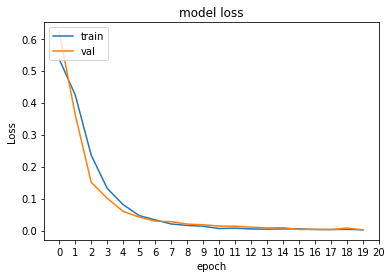

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xticks([i for i in range(21)])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [34]:
# prediction metrics
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [35]:
for batch in test.as_numpy_iterator():
  X_true, y_true = batch
  yhat = (model.predict(X_true) > 0.5).astype(int)

  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)
     

1/1 [==============================] - 0s 29ms/step


In [36]:
print("Precision: ",pre.result().numpy())
print("Recall: ", re.result().numpy())
print("Accuracy: ", acc.result().numpy())

Precision:  1.0
Recall:  0.99902534
Accuracy:  0.996


In [37]:
# testing new data
temp = "Stylish, slick and action-packed film; in one work it’s a ‘Blockbuster’. Film has actions, thrills, bit of suspense and gripping storyline. SRK is back with a bang and has made his fans delighted, a long wait proven worthy. John Abraham looks solid in his negative role and DeepikaP looks stunning, and she has also done some actions in the film along with flourishing her beauty. All the fight sequences and chases are indeed marvelously picturized plus they are very captivating. Full marks to the VFX and CGI as well with that."
temp

'Stylish, slick and action-packed film; in one work it’s a ‘Blockbuster’. Film has actions, thrills, bit of suspense and gripping storyline. SRK is back with a bang and has made his fans delighted, a long wait proven worthy. John Abraham looks solid in his negative role and DeepikaP looks stunning, and she has also done some actions in the film along with flourishing her beauty. All the fight sequences and chases are indeed marvelously picturized plus they are very captivating. Full marks to the VFX and CGI as well with that.'

In [39]:
       # Removing punctuations using replace() method
temp_x = temp.lower()
temp_x = temp_x.split()
temp_x = [wnl.lemmatize(word) for word in temp_x if not word in stopwords.words('english')]
temp_x = ' '.join(temp_x)

In [40]:
temp_x

'stylish, slick action-packed film; one work it’s ‘blockbuster’. film actions, thrills, bit suspense gripping storyline. srk back bang made fan delighted, long wait proven worthy. john abraham look solid negative role deepikap look stunning, also done action film along flourishing beauty. fight sequence chase indeed marvelously picturized plus captivating. full mark vfx cgi well that.'

In [41]:
temp_x = vectorizer(temp_x)
temp_x

<tf.Tensor: shape=(512,), dtype=int64, numpy=
array([ 2945,  4068,  9033,    18,    27,   139, 20257,     1,    18,
        4597,  6442,   205,   784,  3046,   707, 19923,   151,  3982,
          97,   225,  6088,   210,   801, 13596,  1583,   319,  6096,
         115,  1162,  1432,   177,     1,   115,  1397,    80,   222,
         204,    18,   339, 31487,   865,   483,   459,  1074,   843,
        9803,     1,   902,  3959,   377,   831, 76437,  1566,    76,
          12,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,   

In [42]:
import numpy as np
(model.predict(np.expand_dims(temp_x, 0)) > 0.5).astype('int')[0][0]

1/1 [==============================] - 0s 29ms/step


1